# How to work on Colab
## Email Notification & Session Auto Shutdown

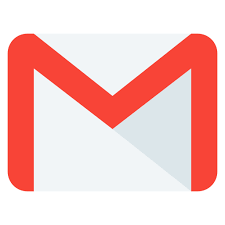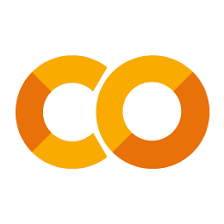

This was supposed to be my baseline to work on [Predict Health Outcomes of Horses (playground-series-s3e22)](https://www.kaggle.com/competitions/playground-series-s3e22) with optuna.<br>
However, I gave too much of `n_trials`, and the Kaggle notebook crashed...<br>
To prevent that to happen again, I decided to move to Colab.<br>

Below is the code to enable email notification & Session Auto Shutdown.<br>
<br>
### Email Notification
You have to search the config for your own email provider.<br>
For gmail users, simply `ctrl` / `cmd` + `f` change `email` to `gmail`.<br><br>
Once you get your App Passwords from<br>`Security` - `2-step verification` setting, enter that password for email_pw,<br> it will work fine for you.<br>
```
import smtplib
from smtplib import SMTPException
from getpass import getpass

email_user = 'your_@email.com'
email_pw = getpass('Enter your Password : ')

mail_from = email_user
mail_to = 'maybe_another_@email.com'

mail_subject = 'TEST'
mail_message_body = 'test_message_body'

mail_message = f'From: {mail_from}\nTo: {mail_to}\nSubject: {mail_subject}\n\n{mail_message_body}'
try:
    server = smtplib.SMTP_SSL('smtp.email.com', 465)
    server.login(email_user, email_pw)
    server.sendmail(mail_from, mail_to, mail_message)
    server.close()
    print("Successfully sent email")
except SMTPException:
    print("Error: unable to send email")
```
<br>

### Session Auto Shutdown:
I believe this is essential for `Pro` & `Pro+` users.<br>
You can place the code below, into `try` & `except` phrase 😊
<br>
```
from google.colab import runtime
runtime.unassign()
```
<br>

Now the baseline starts, you will be able to see the implementations of above functions when you download this and bring it to your colab.

In [ ]:
## Use below in Colab
# !pip install -q optuna tensorflow catboost

In [ ]:
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
import logging
logging.disable(logging.ERROR)
import os
os.environ['TRANSFORMERS_NO_ADVISORY_WARNINGS'] = 'true'
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

## Use below in Colab
# import shutil
# from getpass import getpass

import os
import optuna
import pickle
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm.auto import tqdm
from sklearn.svm import SVC
from functools import partial
from sklearn.metrics import auc
from sklearn.impute import KNNImputer
from tensorflow.keras import Sequential
from xgboost.sklearn import XGBClassifier
from lightgbm import LGBMClassifier as lgb
from sklearn.ensemble import VotingClassifier
from catboost import CatBoostClassifier as cat
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import Input, Dense, ReLU, Softmax, Dropout
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import roc_auc_score, roc_curve, make_scorer, f1_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


In [ ]:
## Use below in Colab
'''
secret = getpass('Enter the secret value: ')
os.environ['KAGGLE_USERNAME'] = 'your_kaggle_username'
os.environ['KAGGLE_KEY'] = secret
'''

In [ ]:
## Use below in Colab
# !kaggle competitions download -c playground-series-s3e22

In [ ]:
## Use below in Colab
'''
from zipfile import ZipFile
t = '/content/playground-series-s3e22.zip'

with ZipFile(t, 'r') as Zobject:
    Zobject.extractall(path='/content/')
'''

In [ ]:
# set configs
is_tuning = True
is_scaling = True
is_pca = False
if is_tuning:
    n_trials=1

# Keras model compile
learning_rate = 1e-3
batch_size = 64
epochs = 20

In [ ]:
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)

seed_everything()

In [ ]:
def calculate_f1(y_true, y_pred):
    f1 = f1_score(y_true, y_pred, average='micro')
    return tf.constant(f1, dtype=tf.float32)

In [ ]:
train = pd.read_csv('/kaggle/input/playground-series-s3e22/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s3e22/test.csv')
submission = pd.read_csv('/kaggle/input/playground-series-s3e22/sample_submission.csv')

## Use below in Colab
'''
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')
submission = pd.read_csv('/content/sample_submission.csv')
'''

In [ ]:
train.head(5)

In [ ]:
train.info()

In [ ]:
mapping = {'yes' : 0, 'no' : 1}
train.surgery = train.surgery.map(mapping)
test.surgery = test.surgery.map(mapping)
train.surgical_lesion = train.surgical_lesion.map(mapping)
test.surgical_lesion = test.surgical_lesion.map(mapping)
train.cp_data = train.cp_data.map(mapping)
test.cp_data = test.cp_data.map(mapping)
mapping = {'adult' : 1, 'young' : 0}
train.age = train.age.map(mapping)
test.age = test.age.map(mapping)
mapping = {'cool' : 0, 'cold' : 1, 'normal' : 2, 'warm' : 3}
train.temp_of_extremities = train.temp_of_extremities.map(mapping)
test.temp_of_extremities = test.temp_of_extremities.map(mapping)
mapping = {'absent' : 0, 'reduced' : 1, 'normal' : 2, 'increased' : 3}
train.peripheral_pulse = train.peripheral_pulse.map(mapping)
test.peripheral_pulse = test.peripheral_pulse.map(mapping)
mapping = {'dark_cyanotic' : 0, 'pale_cyanotic' : 1, 'pale_pink' : 2, 'normal_pink' : 3, 'bright_pink' : 4, 'bright_red' : 5}
train.mucous_membrane = train.mucous_membrane.map(mapping)
test.mucous_membrane = test.mucous_membrane.map(mapping)
mapping = {'less_3_sec' : 0, 'more_3_sec' : 1, '3' : 3}
train.capillary_refill_time = train.capillary_refill_time.map(mapping)
test.capillary_refill_time = test.capillary_refill_time.map(mapping)
mapping = {'depressed' : 0, 'mild_pain' : 1, 'extreme_pain' : 2, 'alert': 3, 'severe_pain' : 4, 'slight' : 5}
train.pain = train.pain.map(mapping)
test.pain = test.pain.map(mapping)
mapping = {'absent' : 0, 'hypomotile' : 1, 'normal' : 2, 'hypermotile': 3, 'distend_small' : 4}
train.peristalsis = train.peristalsis.map(mapping)
test.peristalsis = test.peristalsis.map(mapping)
mapping = {'slight' : 0, 'moderate' : 1, 'none' : 2, 'severe': 3}
train.abdominal_distention = train.abdominal_distention.map(mapping)
test.abdominal_distention = test.abdominal_distention.map(mapping)
mapping = {'slight' : 0, 'significant' : 1, 'none' : 2}
train.nasogastric_tube = train.nasogastric_tube.map(mapping)
test.nasogastric_tube = test.nasogastric_tube.map(mapping)
mapping = {'less_1_liter' : 0, 'more_1_liter' : 1, 'none' : 2, 'slight' : 3}
train.nasogastric_reflux = train.nasogastric_reflux.map(mapping)
test.nasogastric_reflux = test.nasogastric_reflux.map(mapping)
mapping = {'decreased' : 0, 'absent' : 1, 'normal' : 2, 'increased' : 3, 'serosanguious' : 4}
train.rectal_exam_feces = train.rectal_exam_feces.map(mapping)
test.rectal_exam_feces = test.rectal_exam_feces.map(mapping)
mapping = {'distend_small' : 0, 'distend_large' : 1, 'normal' : 2, 'firm' : 3, 'other' : 4}
train.abdomen = train.abdomen.map(mapping)
test.abdomen = test.abdomen.map(mapping)
mapping = {'serosanguious' : 0, 'cloudy' : 1, 'clear' : 2}
train.abdomo_appearance = train.abdomo_appearance.map(mapping)
test.abdomo_appearance = test.abdomo_appearance.map(mapping)
mapping = {'lived' : 0, 'died' : 1, 'euthanized': 2}
train.outcome = train.outcome.map(mapping)

In [ ]:
train.info()

In [ ]:
train.describe()

In [ ]:
imputer =  KNNImputer(n_neighbors=3,)
tr_columns = list(train.columns)
te_columns = list(test.columns)
train[tr_columns] = imputer.fit_transform(train[tr_columns])
test[te_columns] = imputer.fit_transform(test[te_columns])

In [ ]:
train.info()

In [ ]:
[variance_inflation_factor(train, i) for i in range (train.shape[1])]


In [ ]:
def check_vif(df):
    vifs = [variance_inflation_factor(df, i) for i in range(df.shape[1])]
    vif_df = pd.DataFrame({"features":df.columns, "VIF" : vifs})
    vif_df = vif_df.sort_values(by="VIF", ascending=False)
    remove_col = vif_df.iloc[0, 0]
    top_vif = vif_df.iloc[0, 1]
    return vif_df, remove_col, top_vif

In [ ]:
top_vif = 100

while(top_vif > 5):
    vif_df, remove_col, top_vif = check_vif(train)
    print(remove_col, top_vif)
    if top_vif < 5:
        break
    train = train.drop(columns=remove_col)

train

In [ ]:
X = train.drop(columns=['outcome', 'id'])
y = train['outcome']

rf = RandomForestClassifier()
rf.fit(X, y)
# [(col, fi) for col, fi in zip(X.columns, rf.feature_importances_)]
fi_df = pd.DataFrame({'feature': X.columns, 'importance' : rf.feature_importances_})

fi_df.sort_values(by='importance', ascending=False).plot(kind='bar')

In [ ]:
selected_cols = fi_df.sort_values(by='importance', ascending=False)[:10]['feature'].values
selected_cols

In [ ]:
# class imbalance handling

## 1. undersampling
c0 = train[train.outcome==0]
c1 = train[train.outcome==1]
c2 = train[train.outcome==2]

# print(c0.shape, c1.shape, c2.shape)
c0 = c0.sample(n=c1.shape[0])
train = pd.concat([c0, c1])
train.shape

In [ ]:
train.id

In [ ]:
from imblearn.over_sampling import SMOTE

X = train[selected_cols]
y = train['outcome']

X = pd.concat([train.id, X], axis=1)
smote = SMOTE(k_neighbors=5)
X_resampled, y_resampled = smote.fit_resample(X, y)
print(X_resampled.shape, y_resampled.shape)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.15, stratify=y_resampled, random_state=42)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)
X_val.to_csv('test.csv', index=False)

In [ ]:
from sklearn.preprocessing import StandardScaler

if is_scaling:
    scaler = StandardScaler()
    data_ = scaler.fit_transform(X_train.drop(columns='id'))
    X_train = pd.DataFrame(data=data_, columns=(X_train.drop(columns='id')).columns)
    data_ = scaler.transform(X_val.drop(columns='id'))
    X_val = pd.DataFrame(data=data_, columns=(X_val.drop(columns='id')).columns)
    display(X_train)

In [ ]:
if is_pca:
    from sklearn.decomposition import PCA

    pca = PCA(n_components=0.90, random_state=42)
    data_ = pca.fit_transform(X_train)
    X_train = pd.DataFrame(data=data_, columns=[f"PC{i}" for i in range(1, data_.shape[1]+1)])
    data_ = pca.transform(X_val)
    X_val = pd.DataFrame(data=data_, columns=[f"PC{i}" for i in range(1, data_.shape[1]+1)])

    display(X_train)

In [ ]:
svm_params = {"C":93,
#        "kernel":'precomputed',
       "class_weight":'balanced',
       "gamma":'auto',
       'degree':2,
       'coef0':0.45366687207674355,
       'decision_function_shape':'ovo',
       'probability':True,
       'cache_size':1000,
       'random_state':42
      }
lr_params = {'C':82,
             'solver':'sag',
             'max_iter':500,
             'multi_class':'multinomial',
             'class_weight':'balanced',
             'penalty':'l2',
             'tol':0.0004915719520170494,
             'random_state':42,
             'n_jobs':-1
            }
xgb_params = {'booster':'gbtree',
              'colsample_bytree':0.7471481597860571,
              'learning_rate':0.0016662352927965512,
              'max_depth':4,
              'n_estimators':134,
              'num_class':3,
              'random_state':42,
              'reg_lambda':1.0980941643506688
             }
rf_params = {'max_depth':4,
             'max_features':0.7558496313859349,
             'criterion':'gini',
             'n_estimators':67,
             'class_weight':'balanced',
             'random_state':42
            }

catb_params = {'iterations':53,
                'depth':4,
                'bootstrap_type':'Bayesian',
                'l2_leaf_reg':99.29985063946806,
                'learning_rate':0.002375762467646143,
                'bagging_temperature':2.2182206203898582,
                'random_state':42
              }
lgbm_params = {'max_depth':34,
                'objective':'multiclass',
                'num_leaves':3,
                'learning_rate':3.6229230616515386e-09,
                'lambda_l1':3.5132581656827253,
                'lambda_l2':0.013405538678100381,
                'random_state':42
              }

# nn = Sequential([
#     Input(shape=(X_train.shape[1],)),
#     Dense(20), ReLU(), Dropout(0.2),
#     Dense(20), ReLU(), Dropout(0.2),
#     Dense(10), ReLU(), Dropout(0.1),
#     Dense(20), ReLU(), Dropout(0.2),
#     Dense(20), ReLU(), Dropout(0.2),
#     Dense(3), Softmax()
# ])
# nn.summary()


In [ ]:
models = [
    ("svm", SVC(**svm_params)),
    ("lr", LogisticRegression(**lr_params)),
    ("xgb", XGBClassifier(**xgb_params)),
    ("rf", RandomForestClassifier(**rf_params)),
    ("catboost", cat(**catb_params)),
    ("lgbm", lgb(**lgbm_params)),
]

In [ ]:
voting_clf = VotingClassifier(estimators=models,
                              voting='soft',
                              weights=[0.2, 0.2, 0.2, 0.2, 0.1, 0.1]
                             )


In [ ]:
voting_clf.fit(X_train, y_train)


In [ ]:
X_val = pd.read_csv('/kaggle/working/test.csv')
y_pred = voting_clf.predict(X_val)
y_pred

In [ ]:
X_val =  pd.read_csv('/kaggle/working/test.csv')
submission = pd.DataFrame({'id': X_val['id'], 'outcome': y_pred})
submission.to_csv('submission.csv', index=False)

In [ ]:
submission

In [ ]:
# optimizer = Adam(learning_rate=learning_rate)
# loss_fn = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.8)   # [0.8, 0.2] <--> [0.9, 0] // [0, 0.9]
# scheduler = ReduceLROnPlateau(monitor='val_loss',
#                               factor=0.5,
#                               patience=10,
#                               min_lr=1e-6)
# earlystopper = EarlyStopping(monitor='val_loss',
#                              patience=20,
#                              min_delta=1e-2)


# nn.compile(optimizer=optimizer, loss=loss_fn, metrics=[calculate_f1])

# nn_y_train = tf.keras.utils.to_categorical(y_train, num_classes=3)
# nn_y_val = tf.keras.utils.to_categorical(y_val, num_classes=3)

In [ ]:
# print("\nFitting LogisticRegression...")
# lr.fit(X_train, y_train)
# print("\nFitting SVM...")
# svm.fit(X_train, y_train)
# print("\nFitting RandomForest...")
# rf.fit(X_train, y_train)
# print("\nFitting XGBoost...")
# xgb.fit(X_train, y_train)
# print("\nFitting CatBoost...")
# catb.fit(X_train, y_train)
# print("\nFitting Light GBM...")
# lgbm.fit(X_train, y_train)
# # print("\nFitting MLP...")
# # history = nn.fit(X_train, nn_y_train,
# #                 batch_size=batch_size,
# #                 epochs=epochs,
# #                 validation_data=[X_val, nn_y_val],
# #                 callbacks=[scheduler, earlystopper])


evaluation_metric = calculate_f1

print("--- Prediction with LR ---")
lr_pred_train = lr.predict(X_train)
lr_pred_val = lr.predict(X_val)

lr_train_score = evaluation_metric(y_train, lr_pred_train)
lr_val_score = evaluation_metric(y_val, lr_pred_val)

print("Train Score : %.4f" % lr_train_score)
print("Test Score : %.4f" % lr_val_score)

print("--- Prediction with SVM ---")
svm_pred_train = svm.predict(X_train)
svm_pred_val = svm.predict(X_val)

svm_train_score = evaluation_metric(y_train, svm_pred_train)
svm_val_score = evaluation_metric(y_val, svm_pred_val)

print("Train Score : %.4f" % svm_train_score)
print("Test Score : %.4f" % svm_val_score)

print("--- Prediction with RF ---")
rf_pred_train = rf.predict(X_train)
rf_pred_val = rf.predict(X_val)

rf_train_score = evaluation_metric(y_train, rf_pred_train)
rf_val_score = evaluation_metric(y_val, rf_pred_val)

print("Train Score : %.4f" % rf_train_score)
print("Test Score : %.4f" % rf_val_score)

print("--- Prediction with CAT ---")
cat_pred_train = catb.predict(X_train)
cat_pred_val = catb.predict(X_val)

cat_train_score = evaluation_metric(y_train, cat_pred_train)
cat_val_score = evaluation_metric(y_val, cat_pred_val)

print("Train Score : %.4f" % cat_train_score)
print("Test Score : %.4f" % cat_val_score)

print("--- Prediction with LGBM ---")
lgb_pred_train = lgbm.predict(X_train)
lgb_pred_val = lgbm.predict(X_val)

lgb_train_score = evaluation_metric(y_train, lgb_pred_train)
lgb_val_score = evaluation_metric(y_val, lgb_pred_val)

print("Train Score : %.4f" % lgb_train_score)
print("Test Score : %.4f" % lgb_val_score)

In [ ]:
'''
import smtplib
from smtplib import SMTPException
from getpass import getpass

email_user = 'your_@email.com'
email_pw = getpass('Enter your Password :')

mail_from = email_user
mail_to = 'maybe_another_@email.com'

mail_subject = 'TEST'
mail_message_body = 'test_message_body'

mail_message = f'From: {mail_from}\nTo: {mail_to}\nSubject: {mail_subject}\n\n{mail_message_body}'
try:
    server = smtplib.SMTP_SSL('smtp.email.com', 465)
    server.login(email_user, email_pw)
    server.sendmail(mail_from, mail_to, mail_message)
    server.close()
    print("Successfully sent email")
except SMTPException:
    print("Error: unable to send email")
'''

In [ ]:
'''
def lr_optimizer(trial, X, y, K):

    C = trial.suggest_int('C', 5, 100)
    solver = trial.suggest_categorical('solver', ['newton-cg', 'sag', 'lbfgs', 'saga'])


    model = LogisticRegression(C=C,
                               solver=solver,
                               max_iter=500,
                               multi_class='multinomial',
                               class_weight='balanced',
                               random_state=42,
                               n_jobs=-1)


    kf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)
    f1_scores = []

    for train_idx, val_idx in kf.split(X, y):
        X_train = X.iloc[train_idx, :]
        y_train = y.iloc[train_idx]

        X_val = X.iloc[val_idx, :]
        y_val = y.iloc[val_idx]

        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        f1 = f1_score(y_val, preds, average='micro')
        f1_scores.append(f1)


    return -np.mean(f1_scores)
'''

In [ ]:
'''
%%time
try:
    K = 6 # set K of K-Fold
    opt_func = partial(lr_optimizer, X=X_train, y=y_train, K=K)

    if is_tuning:
        lr_study = optuna.create_study(direction="maximize") # determine minimize or maximize sth
        lr_study.optimize(opt_func, n_trials=n_trials)
        mail_subject = 'Logistic Regression Finished'
        mail_message_body = 'Logistic Regression Finished.\
        Starting Random Forest.'

        mail_message = f'From: {mail_from}\nTo: {mail_to}\nSubject: {mail_subject}\n\n{mail_message_body}'

        try:
            server = smtplib.SMTP_SSL('smtp.email.com', 465)
            server.login(email_user, email_pw)
            server.sendmail(mail_from, mail_to, msg=mail_message)
            server.close()
            print("Successfully sent email")
        except SMTPException:
            print("Error: unable to send email")
except:
    mail_subject = 'Logistic Regression Failed'
    mail_message_body = 'Logistic Regression Failed.\
    Shutting Colab off.'

    mail_message = f'From: {mail_from}\nTo: {mail_to}\nSubject: {mail_subject}\n\n{mail_message_body}'

    try:
        server = smtplib.SMTP_SSL('smtp.email.com', 465)
        server.login(email_user, email_pw)
        server.sendmail(mail_from, mail_to, mail_message)
        server.close()
        print("Successfully sent email")
    except SMTPException:
        print("Error: unable to send email")

    from google.colab import runtime
    runtime.unassign()
'''

In [ ]:
'''
def rf_optimizer(trial, X, y, K):
    # define parameter to tune
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_int('max_depth', 4, 20)
    max_features = trial.suggest_float('max_features', 0.6, 0.8, log=True)

    model = RandomForestClassifier(n_estimators=n_estimators,
                                       max_depth=max_depth,
                                       max_features=max_features,
                                       criterion='gini',
                                       class_weight='balanced',
                                       random_state=42
                                      )
    kf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)
    f1_scores = []

    for train_idx, val_idx in kf.split(X, y):
        X_train, X_val = X.iloc[train_idx, :], X.iloc[val_idx, :]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        f1 = f1_score(y_val, preds, average='micro')
        f1_scores.append(f1)
#         print(f1)

    return -np.mean(f1_scores)
'''

In [ ]:
'''
%%time

K = 6 # set K of K-Fold
opt_func = partial(rf_optimizer, X=X_train, y=y_train, K=K)
try:
    if is_tuning:
        rf_study = optuna.create_study(direction="maximize") # determine minimize or maximize sth
        rf_study.optimize(opt_func, n_trials=n_trials)
        mail_subject = 'Random Forest Finished'
        mail_message_body = 'Random Forest Finished.\
        Starting Support Vector Machine.'
        
        mail_message = f'From: {mail_from}\nTo: {mail_to}\nSubject: {mail_subject}\n\n{mail_message_body}'
        
        try:
            server = smtplib.SMTP_SSL('smtp.email.com', 465)
            server.login(email_user, email_pw)
            server.sendmail(mail_from, mail_to, mail_message)
            server.close()
            print("Successfully sent email")
        except SMTPException:
            print("Error: unable to send email")
except:
    mail_subject = 'Random Forest Failed'
    mail_message_body = 'Random Forest Failed.\
    Shutting Colab off.'

    mail_message = f'From: {mail_from}\nTo: {mail_to}\nSubject: {mail_subject}\n\n{mail_message_body}'

    try:
        server = smtplib.SMTP_SSL('smtp.email.com', 465)
        server.login(email_user, email_pw)
        server.sendmail(mail_from, mail_to, mail_message)
        server.close()
        print("Successfully sent email")
    except SMTPException:
        print("Error: unable to send email")

    from google.colab import runtime
    runtime.unassign()
'''

In [ ]:
'''
def svm_optimizer(trial, X, y, K):
    C = trial.suggest_int('C', 1, 100)

    model = SVC(C=C,
                kernel='rbf',
                class_weight='balanced', # if class imbalanced
                gamma='auto',
                decision_function_shape='ovo',
                probability=True,
                cache_size=1000,
                random_state=42
               )

    kf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)
    f1_scores = []

    for train_idx, val_idx in kf.split(X, y):
        X_train = X.iloc[train_idx, :]
        y_train = y.iloc[train_idx]

        X_val = X.iloc[val_idx, :]
        y_val = y.iloc[val_idx]

        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        f1 = f1_score(y_val, preds, average='micro')
        f1_scores.append(f1)


    return -np.mean(f1_scores)
'''

In [ ]:
'''
%%time

K = 6
opt_func = partial(svm_optimizer, X=X_train, y=y_train, K=K)

try:
    if is_tuning:
        svm_study = optuna.create_study(direction="maximize")
        svm_study.optimize(opt_func, n_trials=n_trials)
        mail_subject = 'Support Vector Machine Finished'
        mail_message_body = 'Support Vector Machine Finished.\
        Starting XG Boost.'

        mail_message = f'From: {mail_from}\nTo: {mail_to}\nSubject: {mail_subject}\n\n{mail_message_body}'

        try:
            server = smtplib.SMTP_SSL('smtp.email.com', 465)
            server.login(email_user, email_pw)
            server.sendmail(mail_from, mail_to, mail_message)
            server.close()
            print("Successfully sent email")
        except SMTPException:
            print("Error: unable to send email")
except:
    mail_subject = 'Support Vector Machine Failed'
    mail_message_body = 'Support Vector Machine Failed.\
    Shutting Colab off.'

    mail_message = f'From: {mail_from}\nTo: {mail_to}\nSubject: {mail_subject}\n\n{mail_message_body}'

    try:
        server = smtplib.SMTP_SSL('smtp.email.com', 465)
        server.login(email_user, email_pw)
        server.sendmail(mail_from, mail_to, mail_message)
        server.close()
        print("Successfully sent email")
    except SMTPException:
        print("Error: unable to send email")

    from google.colab import runtime
    runtime.unassign()
'''

In [ ]:
'''
def xgb_optimizer(trial, X, y, K):
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_int('max_depth', 4, 20)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 0.8, log=True)
    learning_rate = trial.suggest_float('learning_rate', 1e-3, 1e-2, log=True)
    num_class = trial.suggest_int('num_class', 2, 10)
    reg_lambda = trial.suggest_float('reg_lambda', 0.1, 2, log=True)
    booster = trial.suggest_categorical('booster', ['gbtree', 'dart'])


    model = XGBClassifier(objective='multi:softmax',
                          n_estimators=n_estimators,
                          max_depth=max_depth,
                          colsample_bytree=colsample_bytree,
                          num_class=num_class,
                          eta=learning_rate,
                          reg_lambda=reg_lambda,
                          random_state=42
                         )


    kf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)
    f1_scores = []

    for train_idx, val_idx in kf.split(X, y):
        X_train = X.iloc[train_idx, :]
        y_train = y.iloc[train_idx]

        X_val = X.iloc[val_idx, :]
        y_val = y.iloc[val_idx]

        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        f1 = f1_score(y_val, preds, average='micro')
        f1_scores.append(f1)


    return -np.mean(f1_scores)
'''

In [ ]:
'''
%%time

K = 6
opt_func = partial(xgb_optimizer, X=X_train, y=y_train, K=K)
try:
    if is_tuning:
        xgb_study = optuna.create_study(direction="maximize")
        xgb_study.optimize(opt_func, n_trials=n_trials)
        mail_subject = 'XG Boost Finished'
        mail_message_body = 'XG Boost Finished.\
        Starting Cat Boost.'

        mail_message = f'From: {mail_from}\nTo: {mail_to}\nSubject: {mail_subject}\n\n{mail_message_body}'

        try:
            server = smtplib.SMTP_SSL('smtp.email.com', 465)
            server.login(email_user, email_pw)
            server.sendmail(mail_from, mail_to, mail_message)
            server.close()
            print("Successfully sent email")
        except SMTPException:
            print("Error: unable to send email")
except:
    mail_subject = 'XG Boost Failed'
    mail_message_body = 'XG Boost Failed.\
    Shutting Colab off.'

    mail_message = f'From: {mail_from}\nTo: {mail_to}\nSubject: {mail_subject}\n\n{mail_message_body}'

    try:
        server = smtplib.SMTP_SSL('smtp.email.com', 465)
        server.login(email_user, email_pw)
        server.sendmail(mail_from, mail_to, mail_message)
        server.close()
        print("Failed, Successfully sent email")
    except SMTPException:
        print("Error: unable to send email")

    from google.colab import runtime
    runtime.unassign()
'''

In [ ]:
'''
def cat_optimizer(trial, X, y, K):
    iterations = trial.suggest_int('iterations', 50, 200)
    depth = trial.suggest_int('depth', 4, 16)
    bootstrap_type = trial.suggest_categorical('bootstrap_type', ['Bayesian'])
    learning_rate = trial.suggest_float('learning_rate', 1e-3, 1e-2, log=True)
    l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 1e-8, 100.0, log=True)
    bagging_temperature = trial.suggest_float('bagging_temperature', 0, 10, log=False)

    model = cat(iterations=iterations,
                depth=depth,
                bootstrap_type=bootstrap_type,
                l2_leaf_reg=l2_leaf_reg,
                learning_rate=learning_rate,
                bagging_temperature=bagging_temperature,
                random_state=42
               )


    kf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)
    f1_scores = []

    for train_idx, val_idx in kf.split(X, y):
        X_train = X.iloc[train_idx, :]
        y_train = y.iloc[train_idx]

        X_val = X.iloc[val_idx, :]
        y_val = y.iloc[val_idx]

        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        f1 = f1_score(y_val, preds, average='micro')
        f1_scores.append(f1)


    return -np.mean(f1_scores)
'''

In [ ]:
'''
%%time

K = 6
opt_func = partial(cat_optimizer, X=X_train, y=y_train, K=K)
try:
    if is_tuning:
        cat_study = optuna.create_study(direction="maximize")
        cat_study.optimize(opt_func, n_trials=n_trials)
        mail_subject = 'Cat Boost Finished'
        mail_message_body = 'Cat Boost Finished.\
        Starting Light GBM.'

        mail_message = f'From: {mail_from}\nTo: {mail_to}\nSubject: {mail_subject}\n\n{mail_message_body}'

        try:
            server = smtplib.SMTP_SSL('smtp.email.com', 465)
            server.login(email_user, email_pw)
            server.sendmail(mail_from, mail_to, mail_message)
            server.close()
            print("Successfully sent email")
        except SMTPException:
            print("Error: unable to send email")
except:
    mail_subject = 'Cat Boost Failed'
    mail_message_body = 'Cat Boost Failed.\
    Shutting Colab off.'

    mail_message = f'From: {mail_from}\nTo: {mail_to}\nSubject: {mail_subject}\n\n{mail_message_body}'

    try:
        server = smtplib.SMTP_SSL('smtp.email.com', 465)
        server.login(email_user, email_pw)
        server.sendmail(mail_from, mail_to, mail_message)
        server.close()
        print("Successfully sent email")
    except SMTPException:
        print("Error: unable to send email")

    from google.colab import runtime
    runtime.unassign()
'''

In [ ]:
'''
def lgbm_optimizer(trial, X, y, K):
    num_leaves = trial.suggest_int('num_leaves', 100, 500)
    max_depth = trial.suggest_int('max_depth', 4, 20)
    boosting_type = trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'rf'])
    learning_rate = trial.suggest_float('learning_rate', 1e-3, 1e-2, log=True)


    model = lgb(max_depth=max_depth,
                objective='multiclass',
                metric='multi_logloss',
                num_leaves=num_leaves,
                boosting_type=boosting_type,
                learning_rate=learning_rate,
                random_state=42
               )


    kf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)
    f1_scores = []

    for train_idx, val_idx in kf.split(X, y):
        X_train = X.iloc[train_idx, :]
        y_train = y.iloc[train_idx]

        X_val = X.iloc[val_idx, :]
        y_val = y.iloc[val_idx]

        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        f1 = f1_score(y_val, preds, average='micro')
        f1_scores.append(f1)


    return -np.mean(f1_scores)
'''

In [ ]:
'''
%%time

K = 6
opt_func = partial(lgbm_optimizer, X=X_train, y=y_train, K=K)
try:
    if is_tuning:
        lgbm_study = optuna.create_study(direction="maximize")
        lgbm_study.optimize(opt_func, n_trials=n_trials)
        mail_subject = 'Light GBM Finished'
        mail_message_body = 'Light GBM Finished.\
        Starting Training Done.'

        mail_message = f'From: {mail_from}\nTo: {mail_to}\nSubject: {mail_subject}\n\n{mail_message_body}'

        try:
            server = smtplib.SMTP_SSL('smtp.email.com', 465)
            server.login(email_user, email_pw)
            server.sendmail(mail_from, mail_to, mail_message)
            server.close()
            print("Successfully sent email")
        except SMTPException:
            print("Error: unable to send email")
except:
    mail_subject = 'Light GBM Failed'
    mail_message_body = 'Light GBM Failed.\
    Shutting Colab off.'

    mail_message = f'From: {mail_from}\nTo: {mail_to}\nSubject: {mail_subject}\n\n{mail_message_body}'

    try:
        server = smtplib.SMTP_SSL('smtp.email.com', 465)
        server.login(email_user, email_pw)
        server.sendmail(mail_from, mail_to, mail_message)
        server.close()
        print("Successfully sent email")
    except SMTPException:
        print("Error: unable to send email")

    from google.colab import runtime
    runtime.unassign()
'''

In [ ]:
'''
# save all studies
if is_tuning:
    with open("rf_study.pk", 'wb') as f:
        pickle.dump(rf_study, f)
    with open("lr_study.pk", 'wb') as f:
        pickle.dump(lr_study, f)
    with open("svm_study.pk", 'wb') as f:
        pickle.dump(svm_study, f)
    with open("xgb_study.pk", 'wb') as f:
        pickle.dump(xgb_study, f)
    with open("cat_study.pk", 'wb') as f:
        pickle.dump(cat_study, f)
    with open("lgbm_study.pk", 'wb') as f:
        pickle.dump(lgbm_study, f)

#     nn.save("./simple_nn_model.keras")
'''

In [ ]:
'''
# visualize experiment logs
def display_experiment_log(study):
    display(study.trials_dataframe())
    print("Best Score: %.4f" % study.best_value)
    print("Best params: ", study.best_trial.params)
    history = study.trials_dataframe()
    display(history[history.value == study.best_value])
    optuna.visualization.plot_optimization_history(study).show()
    optuna.visualization.plot_param_importances(study).show()
'''

In [ ]:
'''
if is_tuning:
    display_experiment_log(rf_study)
'''

In [ ]:
'''
if is_tuning:
    display_experiment_log(lr_study)
'''

In [ ]:
'''
if is_tuning:
    display_experiment_log(svm_study)
'''

In [ ]:
'''
if is_tuning:
    display_experiment_log(xgb_study)
'''

In [ ]:
'''
if is_tuning:
    display_experiment_log(cat_study)
'''

In [ ]:
'''
if is_tuning:
    display_experiment_log(lgbm_study)
'''

In [ ]:
'''
## preprocessing in same way
X_test = test[train.columns.drop("Class")].fillna(test.mean())
if is_scaling:
    X_test = scaler.transform(X_test)

if is_pca:
    data_ = pca.transform(X_test)
    X_test = pd.DataFrame(data=data_, columns=[f"PC{i}" for i in range(1, data_.shape[1]+1)])

X_test
'''

In [ ]:

# # Finalize Models
# if is_tuning:
#     rf_best_params = rf_study.best_params
#     lr_best_params = lr_study.best_params
#     xgb_best_params = xgb_study.best_params
#     svm_best_params = svm_study.best_params
#     lgbm_best_params = lgbm_study.best_params
#     cat_best_params = cat_study.best_params

#     best_rf = RandomForestClassifier(**rf_best_params)
#     best_lr = LogisticRegression(**lr_best_params)
#     best_xgb = XGBClassifier(**xgb_best_params)
#     best_svm = SVC(**svm_best_params, probability=True)
#     best_lgbm = lgb(**lgbm_best_params)
#     best_cat = cat(**cat_best_params)

#     try:
#         mail_subject = 'Best Parameters'

#         mail_message_body = f'''Random Forest : Best Params {rf_best_params}, Best_RF : {best_rf} \n\r\
#         Logistic Regression : Best Params {lr_best_params}, Best_LR : {best_lr} \n\r\
#         XGB : Best Params {xgb_best_params}, Best_xgb : {best_xgb} \n\r\
#         SVM : Best Params {svm_best_params}, Best_svm : {best_svm} \n\r\
#         LGBM : Best Params {lgbm_best_params}, Best_LGBM : {best_lgbm} \n\r\
#         CatBoost : Best Params {cat_best_params}, Best_RF : {best_cat} \n\r\
#         '''

#         mail_message = f'From: {mail_from}\nTo: {mail_to}\nSubject: {mail_subject}\n\n{mail_message_body}'

#         try:
#             server = smtplib.SMTP_SSL('smtp.email.com', 465)
#             server.login(email_user, email_pw)
#             server.sendmail(mail_from, mail_to, mail_message)
#             server.close()
#             print("Successfully sent email")
#         except SMTPException:
#             print("Error: unable to send email")
#     except:
#         mail_subject = 'Best Parameters... Supposed to be...'
#         mail_message_body = f'Something Wrong...'

#         mail_message = f'From: {mail_from}\nTo: {mail_to}\nSubject: {mail_subject}\n\n{mail_message_body}'

#         try:
#             server = smtplib.SMTP_SSL('smtp.email.com', 465)
#             server.login(email_user, email_pw)
#             server.sendmail(mail_from, mail_to, mail_message)
#             server.close()
#             print("Successfully sent email")
#         except SMTPException:
#             print("Error: unable to send email")
#         from google.colab import runtime
#         runtime.unassign()


In [ ]:
'''
print(rf_best_params)
# print(rf_study.best_trial)
print(rf_study.best_value)
'''

In [ ]:
'''
print(lr_best_params)
# print(lr_study.best_trial)
print(lr_study.best_value)
'''

In [ ]:
'''
print(xgb_best_params)
# print(xgb_study.best_trial)
print(xgb_study.best_value)
'''

In [ ]:
'''
print(svm_best_params)
# print(svm_study.best_trial)
print(svm_study.best_value)
'''

In [ ]:
'''
print(lgbm_best_params)
# print(lgbm_study.best_trial)
print(lgbm_study.best_value)
'''

In [ ]:
'''
print(cat_best_params)
# print(cat_study.best_trial)
print(cat_study.best_value)
'''

In [ ]:
# try:
#     # first ensebmle model, then check it.
#     best_rf.fit(X_train, y_train)
#     best_lr.fit(X_train, y_train)
#     best_xgb.fit(X_train, y_train)
#     best_svm.fit(X_train, y_train)
#     best_lgbm.fit(X_train, y_train)
#     best_cat.fit(X_train, y_train)

#     # OOF-prediction
#     v_rf = best_rf.predict(X_val)
#     v_lr = best_lr.predict(X_val)
#     v_xgb = best_xgb.predict(X_val)
#     v_svm = best_svm.predict(X_val)
#     v_lgbm = best_lgbm.predict(X_val)
#     v_cat = best_cat.predict(X_val)

#     print(v_rf.shape, v_lr.shape, v_xgb.shape, v_svm.shape, v_lgbm.shape, v_cat.shape)

#     preds_rf = best_rf.predict(X_test)
#     preds_lr = best_lr.predict(X_test)
#     preds_xgb = best_xgb.predict(X_test)
#     preds_svm = best_svm.predict(X_test)
#     preds_lgbm = best_lgbm.predict(X_test)
#     preds_cat = best_cat.predict(X_test)
#     print(preds_rf.shape, preds_lr.shape, preds_xgb.shape, preds_svm.shape, preds_lgbm.shape, preds_cat.shape)


#     mail_subject = 'Best Parameters'
#     mail_message_body = f'''Random Forest : Best Params {rf_best_params}, Best_RF : {best_rf} \n\
#     Logistic Regression : Best Params {lr_best_params}, Best_LR : {best_lr} \n\
#     XGB : Best Params {xgb_best_params}, Best_xgb : {best_xgb} \n\
#     SVM : Best Params {svm_best_params}, Best_svm : {best_svm} \n\
#     LGBM : Best Params {lgbm_best_params}, Best_LGBM : {best_lgbm} \n\
#     CatBoost : Best Params {cat_best_params}, Best_RF : {best_cat} \n\
#     '''

#     mail_message = f'From: {mail_from}\nTo: {mail_to}\nSubject: {mail_subject}\n\n{mail_message_body}'

#     try:
#         server = smtplib.SMTP_SSL('smtp.email.com', 465)
#         server.login(email_user, email_pw)
#         server.sendmail(mail_from, mail_to, mail_message)
#         server.close()
#         print("Successfully sent email")
#     except SMTPException:
#         print("Error: unable to send email")
# except:
#     mail_subject = 'Best Parameters... Supposed to be...'
#     mail_message_body = f'Something Wrong...'

#     mail_message = f'From: {mail_from}\nTo: {mail_to}\nSubject: {mail_subject}\n\n{mail_message_body}'

#     try:
#         server = smtplib.SMTP_SSL('smtp.email.com', 465)
#         server.login(email_user, email_pw)
#         server.sendmail(mail_from, mail_to, mail_message)
#         server.close()
#         print("Successfully sent email")
#     except SMTPException:
#         print("Error: unable to send email")
#     from google.colab import runtime
#     runtime.unassign()


In [ ]:
# # MLP predictions
# v_nn = nn.predict(X_val)
# preds_nn = nn.predict(X_test)
# print(v_nn.shape, preds_nn.shape)
